<a href="https://colab.research.google.com/github/KRiver28/TIL/blob/master/Bi_directional_m2m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Dense, Input, SimpleRNN, TimeDistributed,  LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Bi_directional 단층 양방향 many_to_many

In [ ]:
# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = np.array([data[i:(i+t_step), :] for i in m])      # feature data
    y = np.array([data[i, :] for i in (m + t_step)])      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = x.reshape(-1, t_step, n_feat)
    y_target = y.reshape(-1, n_feat)
    
    return x_data, y_target


In [ ]:
# 시계열 데이터 (noisy sin)
n_data = 1000
sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data)) + np.random.random(n_data) # noisy sine

# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.332749
1,0.745400
2,0.508904
3,1.416657
4,1.370841


In [ ]:
#기간은 20 으로 정한다.
t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape



((980, 20, 1), (980, 1))

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

# Bidirectional LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
h_lstm=Bidirectional(LSTM(n_hidden,return_sequences=True),merge_mode='ave')(x_input)
#merge_mode 의 종류 sum, concat, ave, mul

x_input.shape, h_lstm.shape

(TensorShape([None, 20, 1]), TensorShape([None, 20, 50]))

In [ ]:
y_output = TimeDistributed(Dense(n_output))(h_lstm)

model = Model(x_input, y_output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_10 (InputLayer)                                [(None, 20, 1)]                                 0                 
                                                                                                                        
 bidirectional_6 (Bidirectional)                      (None, 20, 50)                                  20800             
                                                                                                                        
 time_distributed_2 (TimeDistributed)                 (None, 20, 1)                                   51                
                                                                                                                        
Total params: 2

In [ ]:
# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

Epoch 1/20
10/10 [==============================] - 4s 25ms/step - loss: 0.7201
Epoch 2/20
10/10 [==============================] - 0s 25ms/step - loss: 0.5582
Epoch 3/20
10/10 [==============================] - 0s 27ms/step - loss: 0.3822
Epoch 4/20
10/10 [==============================] - 0s 26ms/step - loss: 0.2417
Epoch 5/20
10/10 [==============================] - 0s 25ms/step - loss: 0.1878
Epoch 6/20
10/10 [==============================] - 0s 26ms/step - loss: 0.1523
Epoch 7/20
10/10 [==============================] - 0s 26ms/step - loss: 0.1405
Epoch 8/20
10/10 [==============================] - 0s 25ms/step - loss: 0.1380
Epoch 9/20
10/10 [==============================] - 0s 25ms/step - loss: 0.1335
Epoch 10/20
10/10 [==============================] - 0s 25ms/step - loss: 0.1315
Epoch 11/20
10/10 [==============================] - 0s 25ms/step - loss: 0.1306
Epoch 12/20
10/10 [==============================] - 0s 24ms/step - loss: 0.1268
Epoch 13/20
10/10 [==================

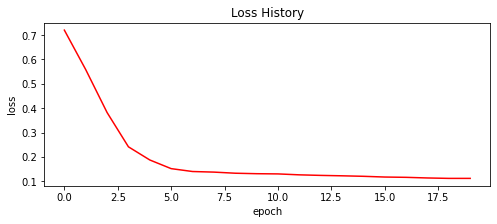

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 200
n_last = 100
last_data = data[-n_last:]  # 원 데이터의 마지막 n_last개만 그려본다

for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = last_data[-t_step:, :].reshape(1, t_step, 1)

    # 다음 값을 예측한다.
    y_hat = model.predict(px)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    last_data = np.vstack([last_data, y_hat[0,-1]])

past_data = last_data[:-n_future, :]
future_data = last_data[-(n_future + 1):, :]

last_data.shape, past_data.shape, future_data.shape

((300, 1), (100, 1), (201, 1))

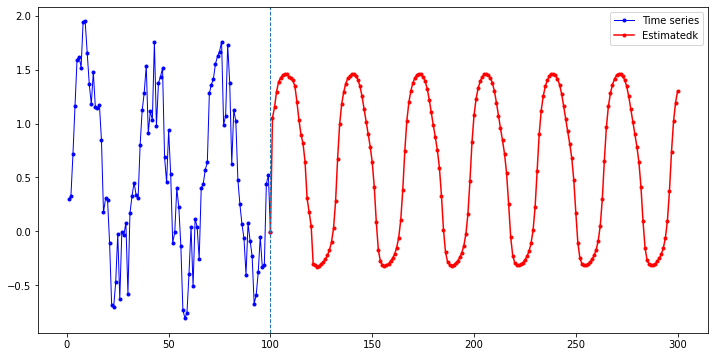

In [ ]:
# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(past_data) + 1)
ax2 = np.arange(len(past_data), len(past_data) + len(future_data))
plt.plot(ax1, past_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, future_data, 'b-o', color='red', markersize=3, label='Estimatedk')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

#Bi_directional 2층 양방향 many_to_many

In [ ]:
# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = np.array([data[i:(i+t_step), :] for i in m])      # feature data
    y = np.array([data[i, :] for i in (m + t_step)])      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = x.reshape(-1, t_step, n_feat)
    y_target = y.reshape(-1, n_feat)
    
    return x_data, y_target


In [ ]:
# 시계열 데이터 (noisy sin)
n_data = 1000
sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data)) + np.random.random(n_data) # noisy sine

# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.351634
1,0.521366
2,0.901764
3,0.995208
4,0.890506


In [ ]:
#기간은 20 으로 정한다.
t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape



((980, 20, 1), (980, 1))

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

# LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
h_lstm1=Bidirectional(LSTM(n_hidden,return_sequences=True),merge_mode='concat')(x_input)
h_lstm2=Bidirectional(LSTM(n_hidden,return_sequences=True),merge_mode='concat')(h_lstm1)

In [ ]:
y_output = TimeDistributed(Dense(n_output))(h_lstm2)


model = Model(x_input, y_output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary(line_length=120)

Model: "model_2"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_14 (InputLayer)                                [(None, 20, 1)]                                 0                 
                                                                                                                        
 bidirectional_7 (Bidirectional)                      (None, 20, 100)                                 20800             
                                                                                                                        
 bidirectional_8 (Bidirectional)                      (None, 20, 100)                                 60400             
                                                                                                                        
 time_distribut

In [ ]:
# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

Epoch 1/20
10/10 [==============================] - 8s 65ms/step - loss: 0.6247
Epoch 2/20
10/10 [==============================] - 1s 67ms/step - loss: 0.2262
Epoch 3/20
10/10 [==============================] - 1s 64ms/step - loss: 0.1326
Epoch 4/20
10/10 [==============================] - 1s 64ms/step - loss: 0.1075
Epoch 5/20
10/10 [==============================] - 1s 63ms/step - loss: 0.0963
Epoch 6/20
10/10 [==============================] - 1s 65ms/step - loss: 0.0924
Epoch 7/20
10/10 [==============================] - 1s 65ms/step - loss: 0.0915
Epoch 8/20
10/10 [==============================] - 1s 62ms/step - loss: 0.0896
Epoch 9/20
10/10 [==============================] - 1s 65ms/step - loss: 0.0906
Epoch 10/20
10/10 [==============================] - 1s 64ms/step - loss: 0.0889
Epoch 11/20
10/10 [==============================] - 1s 67ms/step - loss: 0.0893
Epoch 12/20
10/10 [==============================] - 1s 64ms/step - loss: 0.0883
Epoch 13/20
10/10 [==================

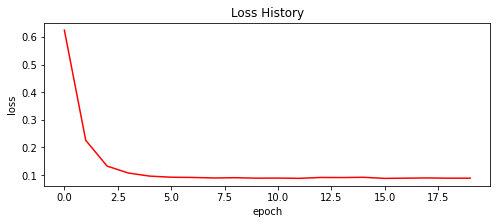

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
n_future = 50
n_last = 100
last_data = data[-n_last:] # 원 데이터의 마지막 n_last개만 그려본다

for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = last_data[-t_step:, :].reshape(1, t_step, 1)

    # 다음 값을 예측한다.
    y_hat = model.predict(px)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    last_data = np.vstack([last_data, y_hat[0,-1]])

past_data = last_data[:-n_future, :]
future_data = last_data[-(n_future + 1):, :]

last_data.shape, past_data.shape, future_data.shape

((150, 1), (100, 1), (51, 1))

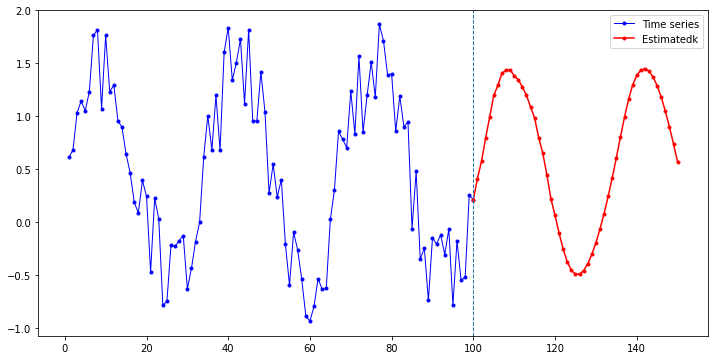

In [ ]:
# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(past_data) + 1)
ax2 = np.arange(len(past_data), len(past_data) + len(future_data))
plt.plot(ax1, past_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, future_data, 'b-o', color='red', markersize=3, label='Estimatedk')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()